In [1]:
import findspark

findspark.init("D:/spark/spark")

In [2]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SQLContext, SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import Word2Vec
from pyspark.sql.functions import *

In [3]:
from pyspark import SparkConf, SparkContext, SQLContext
import os
import re
from operator import add
import io 

    # Create a spark configuration with 20 threads.
    # This code will run locally on master
conf = (SparkConf ()
        .setMaster("local[8]")
        .setAppName("sample app for reading files")
        .set("spark.executor.memory", "2g"))

sc = SparkContext.getOrCreate(conf=conf)



sqlContext = SQLContext (sc)

# read the CSV data file and select only the field labeled as "text"
# this returns a spark data frame

documents = sqlContext.read.load ("5uppp.csv",
                            format='com.databricks.spark.csv',
                            header='true',
                            inferSchema='true').select ("body")

In [4]:
documents.show(10, False)

+---------------------+
|body                 |
+---------------------+
|HEYYYYYYYYY          |
|Two streams today?   |
|heyo                 |
|we back              |
|Hi                   |
|ayy welcome back     |
|tiny pink man is back|
|oh hes back          |
|5up you fell         |
|WutFace              |
+---------------------+
only showing top 10 rows



In [5]:
# To lower and split by space
documents = documents.withColumn("text_splitted", split(lower(col("body")), " "))

In [6]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=100, minCount=0, maxIter=100, inputCol="text_splitted", outputCol="features")
model = word2Vec.fit(documents)

In [7]:
result = model.transform(documents)

In [8]:
synonyms = model.findSynonyms('food', 10)
synonyms.show()

+---------+------------------+
|     word|        similarity|
+---------+------------------+
|delicious|0.5693985223770142|
|      ate| 0.552109956741333|
|suprising|0.4825391471385956|
|     most|0.4640531539916992|
| spago???|0.4608655869960785|
| 5uplurk1|0.4598748981952667|
| food!!!!|0.4529745578765869|
|   5uppog|0.4469703137874603|
| offline?|0.4368714988231659|
|     yous|0.4367394745349884|
+---------+------------------+



In [9]:
# KMeans Clustering
numIterations = 2000
numberClusters = 4
kmeans = KMeans().setMaxIter(numIterations).setK(numberClusters).setSeed(1)
kmeans_model = kmeans.fit(result)

In [10]:
# Make predictions
predictions = kmeans_model.transform(result)

In [11]:
predictions.show()

+--------------------+--------------------+--------------------+----------+
|                body|       text_splitted|            features|prediction|
+--------------------+--------------------+--------------------+----------+
|         HEYYYYYYYYY|       [heyyyyyyyyy]|[0.00377141404896...|         3|
|  Two streams today?|[two, streams, to...|[0.16777215898036...|         3|
|                heyo|              [heyo]|[-0.0258201677352...|         3|
|             we back|          [we, back]|[0.17392321676015...|         3|
|                  Hi|                [hi]|[-0.8025559186935...|         3|
|    ayy welcome back|[ayy, welcome, back]|[0.29627054184675...|         3|
|tiny pink man is ...|[tiny, pink, man,...|[0.09335976168513...|         3|
|         oh hes back|     [oh, hes, back]|[-0.1853107909361...|         0|
|        5up you fell|    [5up, you, fell]|[0.02515641848246...|         3|
|             WutFace|           [wutface]|[-0.0926008969545...|         0|
|           

In [12]:
# Save Output
#predictionsPath = "predictions"
#predictions.select(["body", "prediction"]).write.csv(predictionsPath, mode="overwrite", header="true")

In [13]:
cluster = []
for i in range(numberClusters):
    cluster.append(predictions.filter(col("prediction") == i).select("body"))
    cluster[i].show()

+--------------------+
|                body|
+--------------------+
|         oh hes back|
|             WutFace|
|Professional stre...|
|        scuffed KEKW|
|      welcome back!!|
|           LMAOOOOOO|
|                 LOL|
|                 PFF|
|                 oh?|
|             LMAOOOO|
|        WELCOME BACK|
|        Welcome back|
|                LMAO|
|        welcome back|
|                LMAO|
|               HEYYY|
|                HIII|
|    Hii pro streamer|
|             o hello|
|                hiii|
+--------------------+
only showing top 20 rows

+------+
|  body|
+------+
|lmaooo|
|LMAOOO|
|LMAOOO|
|lmaooo|
|Lmaooo|
| LMAOO|
|   POG|
|   POG|
|   POG|
|   Pog|
|   Pog|
|   POG|
|   POG|
|   POG|
|   pog|
|   POG|
|   Pog|
|   POG|
|   POG|
|   pog|
+------+
only showing top 20 rows

+--------------------+
|                body|
+--------------------+
|5upPrime 5upPrime...|
|     Hiiii 5upL 5upL|
| 5upL 5upL 5upL 5upL|
|      5upL 5upL 5upL|
|      5upL 5upL 5u

In [14]:
from pyspark import SparkConf, SparkContext, SQLContext
import os
import re
from operator import add
import io 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
def get_keyval(row):

    text = row.body
    text=re.sub("\\W"," ",text)

    words = text.lower ().split (" ")

    return [[w, 1] for w in words]


def get_counts(df):

    df.show (2, False)

    mapped_rdd = df.rdd.flatMap (lambda row: get_keyval (row))

    counts_rdd = mapped_rdd.reduceByKey (add)

    word_count = counts_rdd.collect ()
    word_count.sort(key = lambda x: x[1],reverse=True)
    stop_words = set(stopwords.words('english'))
    words = []
    # print the counts
    for word in word_count:
        if word[0] not in stop_words:
            words.append(word)
    return words

+-----------+
|body       |
+-----------+
|oh hes back|
|WutFace    |
+-----------+
only showing top 2 rows



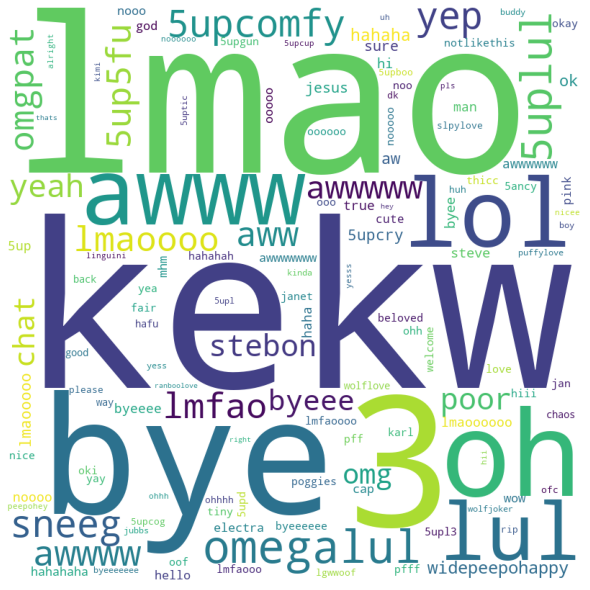

+------+
|body  |
+------+
|lmaooo|
|LMAOOO|
+------+
only showing top 2 rows



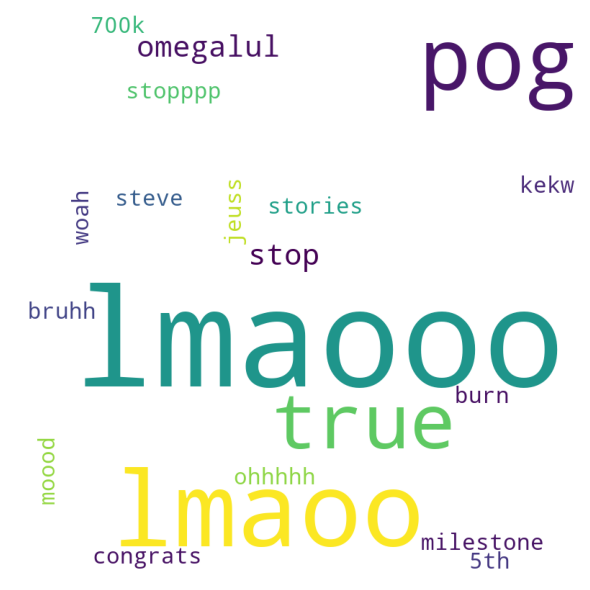

+--------------------------------------------+
|body                                        |
+--------------------------------------------+
|5upPrime 5upPrime 5upPrime 5upPrime 5upPrime|
|Hiiii 5upL 5upL                             |
+--------------------------------------------+
only showing top 2 rows



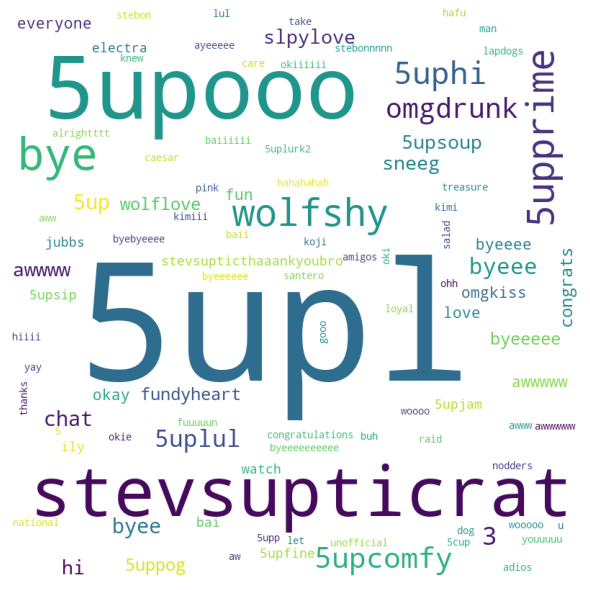

+------------------+
|body              |
+------------------+
|HEYYYYYYYYY       |
|Two streams today?|
+------------------+
only showing top 2 rows



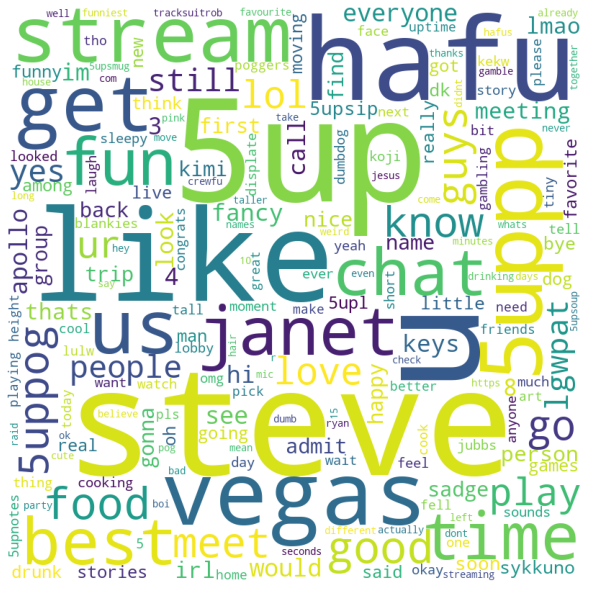

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
words = []
for c in cluster:
    d = dict(get_counts (c))
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(d)
  
    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()